<a href="https://colab.research.google.com/github/kugmax/tensorflow_learn/blob/master/MNIST_pure_(with_overfitting).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

In [0]:
sess = tf.Session()

In [3]:
data_dir = 'temp'
mnist = read_data_sets(data_dir)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting temp/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting temp/train-labels-idx1-ubyte.gz
Extracting temp/t10k-images-idx3-ubyte.gz
Extracting temp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
x_train = np.array([np.reshape(x, (28, 28)) for x in mnist.train.images ])

In [0]:
x_test = np.array([np.reshape(x, (28, 28)) for x in mnist.test.images ])

In [0]:
y_train = mnist.train.labels
y_test = mnist.test.labels

In [7]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((55000, 28, 28), (55000,), (10000, 28, 28), (10000,))

In [0]:
batch_size = 100
lr = 0.005
epoches = 500

img_width = x_train[0].shape[0]
img_height = x_train[0].shape[1]

target_size = max(y_train) + 1
channels = 1

In [0]:
eval_size = 500
eval_every = 5

conv1_features = 25
conv2_features = 50

max_pool1_size = 2
max_pool2_size = 2

fully_connected_size1 = 100

In [0]:
x_input_shape = (batch_size, img_width, img_height, channels)
x = tf.placeholder(tf.float32, shape=x_input_shape)
y = tf.placeholder(tf.int32, shape=(batch_size))

eval_input_shape = (eval_size, img_width, img_height, channels)
eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
eval_target = tf.placeholder(tf.int32, shape=(eval_size))

In [0]:
conv1_weight = tf.Variable(tf.truncated_normal([4, 4, channels, conv1_features], stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

In [0]:
conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features], stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

In [0]:
result_width = img_width // (max_pool1_size * max_pool2_size)
result_height = img_height // (max_pool1_size * max_pool2_size)

full1_input_size = result_width * result_height * conv2_features
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))

full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], stddev=0.1, dtype=tf.float32))

full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

In [0]:
def conv_net(input_data):
  print(input_data.shape, conv1_weight.shape)
  
  conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
  relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
  max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool1_size, max_pool1_size, 1], strides=[1, max_pool1_size, max_pool1_size, 1], padding='SAME')
  
  print(max_pool1.shape, conv2_weight.shape)
  
  conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='SAME')
  relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
  max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool2_size, max_pool2_size, 1], strides=[1, max_pool2_size, max_pool2_size, 1], padding='SAME')
  
  final_conv_shape = max_pool2.get_shape().as_list()
  final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
  flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])
  
  fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
  final_model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
  
  return final_model_output

In [15]:
train_output = conv_net(x)
test_output = conv_net(eval_input)

(100, 28, 28, 1) (4, 4, 1, 25)
(100, 14, 14, 25) (4, 4, 25, 50)
(500, 28, 28, 1) (4, 4, 1, 25)
(500, 14, 14, 25) (4, 4, 25, 50)


In [0]:
loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits=train_output, labels=y)
)

In [0]:
train_prediction = tf.nn.softmax(train_output)
test_prediction = tf.nn.softmax(test_output)

In [0]:
def get_accurency(logits, targets):
  batch_predictions = np.argmax(logits, axis=1)
  num_correct = np.sum(np.equal(batch_predictions, targets))
  return (100. * num_correct / batch_predictions.shape[0])

In [0]:
optimizer = tf.train.MomentumOptimizer(lr, 0.9)
train_step = optimizer.minimize(loss)

In [0]:
init = tf.global_variables_initializer()
sess.run(init)

In [27]:
train_loss = []
train_acc = []
test_acc = []
for i in range(epoches):
  rand_index = np.random.choice(len(x_train), size=batch_size)
  
  rand_x = x_train[rand_index]
  rand_x = np.expand_dims(rand_x, 3)
  
  rand_y = y_train[rand_index]
  
  train_dict = {x: rand_x, y: rand_y}  
  sess.run(train_step, feed_dict=train_dict)
  tmp_train_loss, train_preds = sess.run([loss, train_prediction], feed_dict=train_dict)
  
  tmp_train_acc = get_accurency(train_preds, rand_y)
  
  if (i + 1) % eval_every == 0:
    eval_index = np.random.choice(len(x_test), size=eval_size)
    eval_x = x_test[eval_index]
    eval_x = np.expand_dims(eval_x, 3)
    eval_y = y_test[eval_index]
    test_dict = {eval_input: eval_x, eval_target:eval_y}
    test_preds = sess.run(test_prediction, feed_dict=test_dict)
    
    tmp_test_acc = get_accurency(test_preds, eval_y)
    
    train_loss.append(tmp_train_loss)
    train_acc.append(tmp_train_acc)
    test_acc.append(tmp_test_acc)
    
    acc_and_loss = [ (i+1), tmp_train_loss, tmp_train_acc, tmp_test_acc ]
    acc_and_loss = [ np.round(x, 2) for x in acc_and_loss]
    
    print('Epoch # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Epoch # 5. Train Loss: 1.83. Train Acc (Test Acc): 58.00 (56.00)
Epoch # 10. Train Loss: 1.65. Train Acc (Test Acc): 64.00 (63.80)
Epoch # 15. Train Loss: 1.34. Train Acc (Test Acc): 65.00 (63.00)
Epoch # 20. Train Loss: 1.12. Train Acc (Test Acc): 70.00 (74.20)
Epoch # 25. Train Loss: 0.79. Train Acc (Test Acc): 72.00 (76.40)
Epoch # 30. Train Loss: 0.62. Train Acc (Test Acc): 82.00 (74.60)
Epoch # 35. Train Loss: 0.50. Train Acc (Test Acc): 88.00 (82.20)
Epoch # 40. Train Loss: 0.52. Train Acc (Test Acc): 83.00 (81.00)
Epoch # 45. Train Loss: 0.46. Train Acc (Test Acc): 87.00 (85.00)
Epoch # 50. Train Loss: 0.36. Train Acc (Test Acc): 89.00 (84.20)
Epoch # 55. Train Loss: 0.41. Train Acc (Test Acc): 89.00 (86.20)
Epoch # 60. Train Loss: 0.29. Train Acc (Test Acc): 92.00 (86.80)
Epoch # 65. Train Loss: 0.40. Train Acc (Test Acc): 91.00 (86.80)
Epoch # 70. Train Loss: 0.31. Train Acc (Test Acc): 89.00 (85.80)
Epoch # 75. Train Loss: 0.29. Train Acc (Test Acc): 91.00 (84.60)
Epoch # 80.

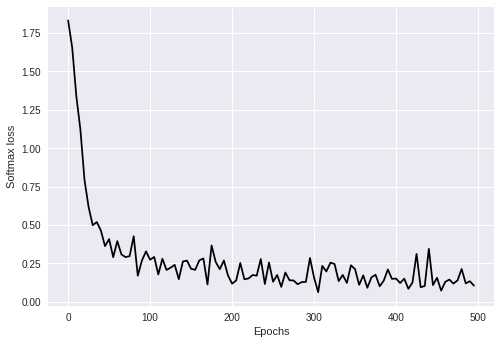

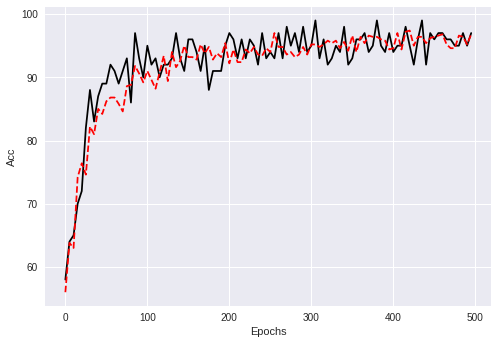

In [31]:
eval_indices = range(0, epoches, eval_every)

plt.plot(eval_indices, train_loss, 'k-')
plt.xlabel('Epochs')
plt.ylabel('Softmax loss')
plt.show()

plt.plot(eval_indices, train_acc, 'k-', label='Train acc')
plt.plot(eval_indices, test_acc, 'r--', label='Test acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')        
plt.show()